<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/testSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import time
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

##使用pytorch实现之前使用numpy实现的两层神经网络

device=torch.device("cpu")
#选择是使用cpu进行计算还是gpu
#device=torch.device("cuda")
dtype=torch.float

#神经网络参数定义：
N,D_in,D_out,H=100,10,1,2
# N：代表64个人
# D_in:代表每个人输入到神经网络1000个数据点
# D_out:代表每个人从神经网络输出10个数据点
# H:代表该神经网络含有100个隐藏层

x=torch.randn(N,D_in,device=device)
torch.nn.init.normal_(x, 0, 1)
#定义输入到神经网络之前的数据矩阵，大小为64*1000
#这里需要注意的是我们需要指定device为我们刚刚设定好的device
v=torch.rand(D_in,1,device=device)
v=v/v.norm()
y=x.mm(v)
y=y.clamp(min=0)
#y=torch.randn(N,D_out,device=device)
#定义从神经网络输出的的数据矩阵，大小为64*10
w_1=torch.randn(D_in,H,device=device)
torch.nn.init.normal_(w_1, 0, 0.1)
#大小为1000*100
w_2=torch.ones(H,D_out,device=device)
#大小为100*10

In [17]:
learning_rate=0.0005
hidden=[1,2,5,10]
loss_data=np.zeros((4,2000))
loss_log=np.zeros((4,2000))
for i in range(4):
  H=hidden[i]
  w_1=torch.randn(D_in,H,device=device,dtype=dtype)
  torch.nn.init.normal_(w_1, 0, 0.1)
  #大小为1000*100
  w_2=torch.ones(H,D_out,device=device,dtype=dtype)
  for it in range(2000):
      #forword pass
      h=x.mm(w_1)
      #numpy中的点乘np.dot是数学意义上的向量内积
      #print(h.shape)
      #打印矩阵维度信息
      h_relu=h.clamp(min=0)
      #定义relu 函数，在pytorch中使用.clamp方法
      y_hat=h_relu.mm(w_2)
      #大小为64*10

      #计算损失compute loss
      loss=(y_hat-y).pow(2).sum()
      #估计值与真实值之间差值的平方和再取和,替换numpy的square方法
      if(it%100==0):
        print(it,loss)
      loss_data[i][it]=loss.item()
      if(i!=0):
        loss_log[i][it]=torch.log(loss)/torch.log(torch.Tensor([learning_rate*it]))

      #计算梯度，主要是对(y_hat-y)^2求各项偏导
      y_hat_grad=2*(y_hat-y)
      w_2_grad=h_relu.t().mm(y_hat_grad)
      h_relu_grad=y_hat_grad.mm(w_2.t())
      h_grad=h_relu_grad.clone()
      h_grad[h<0]=0
      w_1_grad=x.t().mm(h_grad)
      # loss.backward()

      # with torch.no_grad():
      #   w_1-=learning_rate*w_1.grad
      #   w_1.grad.zero_()

      #更新w_1和w_2的权值
      w_1=w_1-learning_rate*w_1_grad
      #w_2=w_2-learning_rate*w_2_grad

0 tensor(46.0557)
100 tensor(0.3072)
200 tensor(0.0200)
300 tensor(0.0010)
400 tensor(4.3056e-05)
500 tensor(1.9740e-06)
600 tensor(9.1806e-08)
700 tensor(4.4388e-09)
800 tensor(2.6807e-10)
900 tensor(1.1437e-10)
1000 tensor(1.1437e-10)
1100 tensor(1.1437e-10)
1200 tensor(1.1437e-10)
1300 tensor(1.1437e-10)
1400 tensor(1.1437e-10)
1500 tensor(1.1437e-10)
1600 tensor(1.1437e-10)
1700 tensor(1.1437e-10)
1800 tensor(1.1437e-10)
1900 tensor(1.1437e-10)
0 tensor(40.2114)
100 tensor(0.1790)
200 tensor(0.0319)
300 tensor(0.0111)
400 tensor(0.0048)
500 tensor(0.0023)
600 tensor(0.0012)
700 tensor(0.0007)
800 tensor(0.0004)
900 tensor(0.0003)
1000 tensor(0.0002)
1100 tensor(0.0001)
1200 tensor(0.0001)
1300 tensor(8.1724e-05)
1400 tensor(6.1135e-05)
1500 tensor(4.5882e-05)
1600 tensor(3.4546e-05)
1700 tensor(2.6096e-05)
1800 tensor(1.9780e-05)
1900 tensor(1.5043e-05)
0 tensor(39.2250)
100 tensor(0.0435)
200 tensor(0.0074)
300 tensor(0.0027)
400 tensor(0.0012)
500 tensor(0.0006)
600 tensor(0.0003

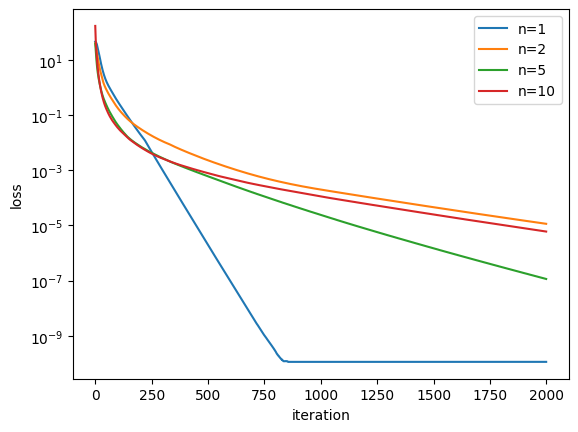

In [18]:
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data[0],label='n=1')
ax.plot(loss_data[1],label='n=2')
ax.plot(loss_data[2],label='n=5')
ax.plot(loss_data[3],label='n=10')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.show()

In [19]:
# SAM
def loss(w_1):
  h=x.mm(w_1)
  h_relu=h.clamp(min=0)
  y_hat=h_relu.mm(w_2)

  loss=(y_hat-y).pow(2).sum()
  return loss

def loss_grad(w_1):
  h=x.mm(w_1)
  h_relu=h.clamp(min=0)
  y_hat=h_relu.mm(w_2)

  loss=(y_hat-y).pow(2).sum()

  y_hat_grad=2*(y_hat-y)
  w_2_grad=h_relu.t().mm(y_hat_grad)
  h_relu_grad=y_hat_grad.mm(w_2.t())
  h_grad=h_relu_grad.clone()
  h_grad[h<0]=0
  w_1_grad=x.t().mm(h_grad)

  return w_1_grad

rou=0.05
learning_rate=0.0005
hidden=[1,2,5,10]
loss_data3=np.zeros((4,2000))
loss_log=np.zeros((4,2000))
for i in range(4):
  H=hidden[i]
  w_1=torch.randn(D_in,H,device=device,dtype=dtype)
  torch.nn.init.normal_(w_1, 0, 0.1)
  #大小为1000*100
  w_2=torch.ones(H,D_out,device=device,dtype=dtype)
  for it in range(2000):
      #forword pass
      loss_data3[i][it]=loss(w_1).item()
      ori_grad=loss_grad(w_1)
      epi=rou*ori_grad/ori_grad.norm()
      g=loss_grad(epi+w_1)
      w_1-=learning_rate*g

      if(it%100==0):
        print(it,loss(w_1))

0 tensor(39.4883)
100 tensor(0.1372)
200 tensor(0.0003)
300 tensor(0.0003)
400 tensor(0.0003)
500 tensor(0.0003)
600 tensor(0.0003)
700 tensor(0.0003)
800 tensor(0.0003)
900 tensor(0.0003)
1000 tensor(0.0003)
1100 tensor(0.0003)
1200 tensor(0.0003)
1300 tensor(0.0003)
1400 tensor(0.0003)
1500 tensor(0.0003)
1600 tensor(0.0003)
1700 tensor(0.0003)
1800 tensor(0.0003)
1900 tensor(0.0003)
0 tensor(41.0015)
100 tensor(0.0308)
200 tensor(0.0121)
300 tensor(0.0076)
400 tensor(0.0064)
500 tensor(0.0055)
600 tensor(0.0057)
700 tensor(0.0060)
800 tensor(0.0061)
900 tensor(0.0060)
1000 tensor(0.0059)
1100 tensor(0.0059)
1200 tensor(0.0060)
1300 tensor(0.0059)
1400 tensor(0.0061)
1500 tensor(0.0059)
1600 tensor(0.0060)
1700 tensor(0.0060)
1800 tensor(0.0060)
1900 tensor(0.0060)
0 tensor(32.9061)
100 tensor(0.1410)
200 tensor(0.1080)
300 tensor(0.0894)
400 tensor(0.0622)
500 tensor(0.0573)
600 tensor(0.0549)
700 tensor(0.0500)
800 tensor(0.0487)
900 tensor(0.0482)
1000 tensor(0.0460)
1100 tensor(0

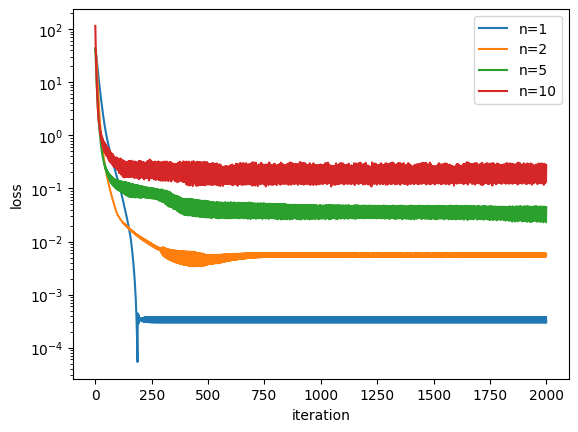

In [21]:
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data3[0],label='n=1')
ax.plot(loss_data3[1],label='n=2')
ax.plot(loss_data3[2],label='n=5')
ax.plot(loss_data3[3],label='n=10')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.show()

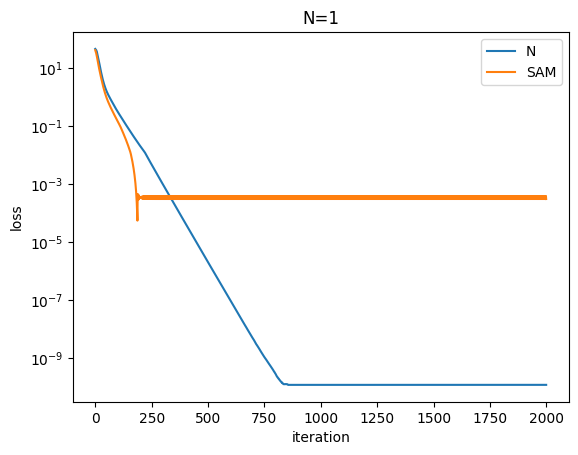

In [25]:
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data[0],label='N')
ax.plot(loss_data3[0],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.title('N=1')
ax.legend()
plt.show()

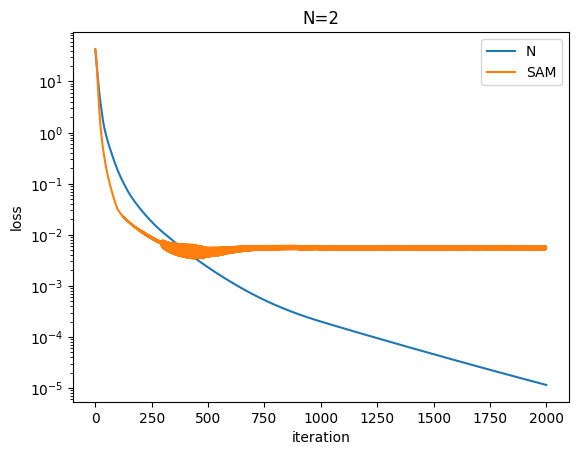

In [26]:
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data[1],label='N')
ax.plot(loss_data3[1],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=2')
plt.show()

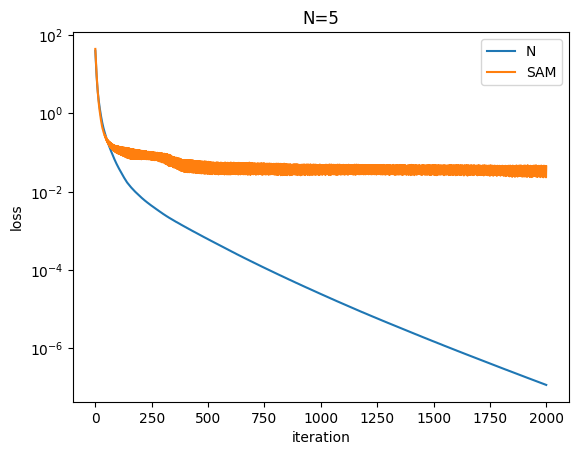

In [27]:
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data[2],label='N')
ax.plot(loss_data3[2],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=5')
plt.show()

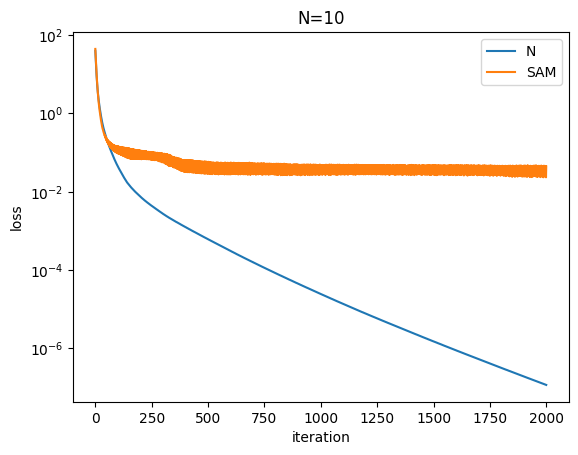

In [28]:
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data[2],label='N')
ax.plot(loss_data3[2],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=10')
plt.show()